/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape = (10976, 44)
hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.1763618194955034
1  6.813530694319375
2  6.498005659587214
3  6.217792111518373
4  5.986687189917898
5  5.780736698403407
6  5.594632757519777
7  5.430503578433688
8  5.293917243115825
9  5.167705752638196
10  5.060692993226883
11  4.959071304308731
12  4.87358701527887
13  4.794664249704415
14  4.727289467564125
15  4.667674635474578
16  4.620436076178354
17  4.583805717837967
18  4.549921146901314
19  4.525586185901847
20  4.493070574300186
21  4.4600329757031405
22  4.430339895187383
23  4.4047737401875615
24  4.387489517201111
25  4.373537768851329
26  4.354722687854709
27  4.342214164016355
28  4.33121220489911
29  4.321879091394116
30  4.314353527598779
31  4.3095931315571026
32  4.301457269958156
33  4.297053186039743
34  4.292257693729596
35  4.286293906351884
36  4.283022533816073
37  4.281386502422115
38  4.2784316148532975
39  4.2771910600402085
40  4.27428911761566
41  4.2

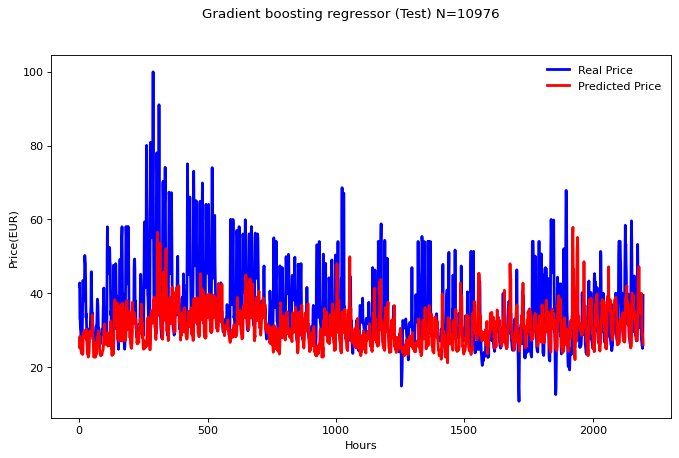

In [4]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20

path = "/content/drive/MyDrive/Colab Notebooks/Project/PTop30_Weather+extend.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%m/%d/%Y %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
Y = Y.to_numpy()


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]
X = X.to_numpy()
Pred_index = X.shape
print("Shape = "+str(Pred_index))



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape = (10976, 44)
hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.175374467543604
1  6.813701491724121
2  6.508000029924308
3  6.2281987033175
4  5.996014756457114
5  5.7904715712482995
6  5.6101228814913675
7  5.441224687610316
8  5.299499699389835
9  5.1730099415672255
10  5.067424797232445
11  4.9633282830350405
12  4.872502327730724
13  4.79777248413506
14  4.728998988859216
15  4.677016807568001
16  4.630979559568864
17  4.594400031158565
18  4.561334312977734
19  4.5326967318241795
20  4.485093345571294
21  4.452388167161375
22  4.422363766621843
23  4.397509284871019
24  4.373169317359669
25  4.357232714313423
26  4.345188381695844
27  4.334671641696808
28  4.322908801582049
29  4.313180602229596
30  4.302494409671357
31  4.29477928405295
32  4.290176814672027
33  4.280919022448562
34  4.274539542367349
35  4.2698124114313485
36  4.26505529898495
37  4.26203251634365
38  4.258872216198433
39  4.257266701646495
40  4.256912626616585
41  4.2496

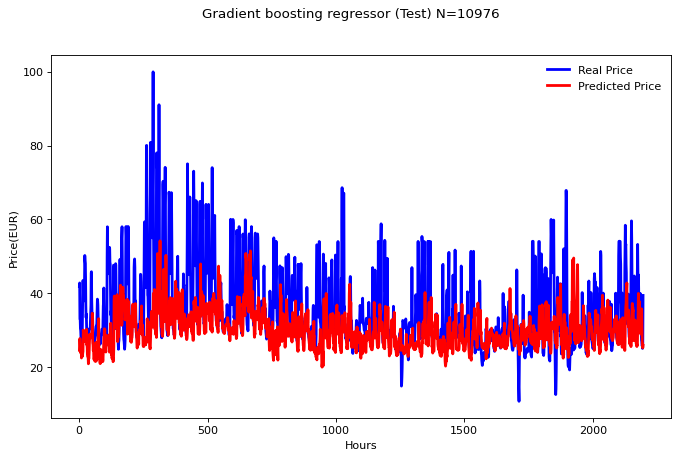

In [5]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20

path = "/content/drive/MyDrive/Colab Notebooks/Project/STop30_Weather+extend.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%m/%d/%Y %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
Y = Y.to_numpy()


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]
X = X.to_numpy()
Pred_index = X.shape
print("Shape = "+str(Pred_index))



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape = (10976, 44)
hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.187785940392279
1  6.836644463614989
2  6.521968219845046
3  6.245039994955267
4  6.014210982502492
5  5.812253976209832
6  5.624774816225924
7  5.472095632131096
8  5.335646372399612
9  5.223237465632632
10  5.121368229303809
11  5.026202040666527
12  4.954904252967893
13  4.899647864748856
14  4.846909928171268
15  4.799497704464306
16  4.757222350466021
17  4.720068130995728
18  4.687311569969597
19  4.662446349646682
20  4.638262295514145
21  4.618399399251443
22  4.603613946450806
23  4.589147951979829
24  4.564490485244028
25  4.542579818763864
26  4.527072442875536
27  4.518296871986369
28  4.504458621331198
29  4.49766824021472
30  4.486504705682784
31  4.479563143027713
32  4.47565058887539
33  4.471928753511081
34  4.465829854373535
35  4.463992754606099
36  4.462194497102406
37  4.459913913624938
38  4.459230210494931
39  4.452385426670547
40  4.451494405250969
41  4.449514

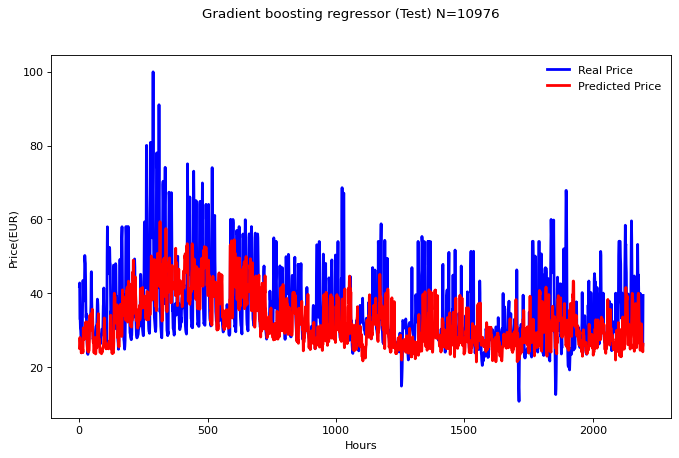

In [6]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20

path = "/content/drive/MyDrive/Colab Notebooks/Project/LRTop30_Weather+extend.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%m/%d/%Y %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
Y = Y.to_numpy()


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]
X = X.to_numpy()
Pred_index = X.shape
print("Shape = "+str(Pred_index))



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape = (10976, 44)
hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.190270984818159
1  6.838946746472754
2  6.529281888991763
3  6.268149520279196
4  6.030300198686466
5  5.831835977806338
6  5.647912365844146
7  5.486908380771189
8  5.353823365439428
9  5.225209853376974
10  5.111845524554855
11  5.025036837231936
12  4.946172036572299
13  4.8818090894681045
14  4.818700122747531
15  4.768169903017239
16  4.724699184646109
17  4.68382597518753
18  4.634797207652653
19  4.594725425095787
20  4.562042416675824
21  4.530724885022689
22  4.506785601161545
23  4.477010737332162
24  4.457586555529567
25  4.445871246245382
26  4.434064449717726
27  4.412000324834975
28  4.404592805943062
29  4.397671265787612
30  4.3935405974643205
31  4.387692475424445
32  4.382057877898057
33  4.377597719002935
34  4.364227252595587
35  4.361855546992775
36  4.358126914202053
37  4.347084032309739
38  4.330481787767072
39  4.323593564184827
40  4.320290849441885
41  4.318

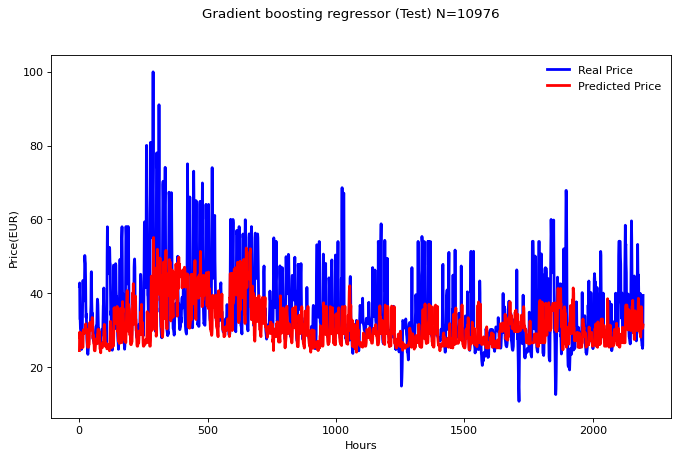

In [7]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20

path = "/content/drive/MyDrive/Colab Notebooks/Project/GBMTop30_Weather+extend.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%m/%d/%Y %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
Y = Y.to_numpy()


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]
X = X.to_numpy()
Pred_index = X.shape
print("Shape = "+str(Pred_index))



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()
